# Generate MART and NYES Vector Integration Libraries
- randomly insert vector into location in the genome
- simulate PE reads using BSBolt
- align and try to detect vector integration 

## Notebook Setup

In [84]:
import gzip
import io
import os 
import pickle
import random
import subprocess
import urllib.request

# import third party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

In [83]:
# import local libraries
from BSBolt.Align.AlignmentHelpers import convert_alpha_numeric_cigar, get_mapping_length
from BSBolt.Index.WholeGenomeBuild import WholeGenomeIndexBuild
from BSBolt.Simulate.SimulateMethylatedReads import SimulateMethylatedReads
from BSBolt.Utils.UtilityFunctions import get_external_paths
from IntegrationSiteSearch.DetectIntegration import ProcessVectorSpanningReads
from IntegrationSiteSearch.IntegrationUtils import get_spanning_reads

In [3]:
bt2_path, art_path = get_external_paths()

In [4]:
pwd = os.getcwd() + '/'

In [5]:
ucsc_hg38 = 'https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz'

In [6]:
if not os.path.exists(f'{pwd}SimulationData/hg38.fa.gz'):
    urllib.request.urlretrieve(ucsc_hg38, f'{pwd}SimulationData/hg38.fa.gz')

## Import Sequence Data

In [7]:
# get hg38 reference with lambda phage control attached

hg38 = {}

with gzip.open(f'{pwd}SimulationData/hg38.fa.gz') as genome:
    contig_seq = ''
    chrom = None
    for line in io.BufferedReader(genome):
        processed_line = line.decode('utf-8').strip()
        if '>' == processed_line[0]:
            if chrom:
                hg38[chrom] = contig_seq
            contig_seq = ''
            chrom = processed_line[1:]
        else:
            contig_seq = contig_seq + processed_line
    hg38[chrom] = contig_seq

In [8]:
# import NYES and Mart vector sequences 
mart1 = 'pMSGV1-MART1TCR.txt'
nyes =  'pMSGV1-1G4_A_LY_RetroNYESO1.txt'

In [9]:
vector_seq = {}

for vector in [mart1, nyes]:
    vector_label = vector.replace('-', '_').replace('.txt', '')
    seq = ''
    with open(f'{pwd}SimulationData/{vector}', 'r') as vec_seq:
        for line in vec_seq:
            processed_line = line.strip().replace(' ', '')
            seq = seq + ''.join([base for base in processed_line if not base.isdigit()])
    vector_seq[vector_label] = seq
    

In [10]:
if not os.path.exists(f'{pwd}SimulationData/hg38_sim.fa'):
    out = open(f'{pwd}SimulationData/hg38_sim.fa', 'w')
    for chrom, seq in tqdm(hg38.items()):
        out.write(f'>{chrom}\n')
        out.write(f'{seq}\n')
    for chrom, seq in vector_seq.items():
        out.write(f'>{chrom}\n')
        out.write(f'{seq}\n')
    out.close()

## Simulated vector integration libraries
- select the number of integration events
- select random integration sites
- generate 2 mart and 2 nyes datasets

In [11]:
integration_events = [events + 15 for events in range(10)]

In [12]:
vector_integration_samples = ['pMSGV1_MART1TCR', 'pMSGV1_MART1TCR', 'pMSGV1_MART1TCR', 'pMSGV1_1G4_A_LY_RetroNYESO1', 'pMSGV1_1G4_A_LY_RetroNYESO1', 'pMSGV1_1G4_A_LY_RetroNYESO1']

In [13]:
simulation_integration_parameters = {}

for count, vector in enumerate(vector_integration_samples):
    sim_label = f'{count}_{vector}'
    int_events = random.sample(integration_events, 1)[0]
    integration_locations = []
    integration_sequences = []
    while len(integration_locations) < int_events:
        int_chrom = random.sample(list(hg38.keys()), 1)[0]
        if len(int_chrom) > 5 or not int_chrom[-1].isdigit():
            continue
        # get chromosome sequence
        chrom_seq = hg38[int_chrom]
        # select simulation position 
        int_pos = random.randint(0, len(chrom_seq))
        # retrieve integration position 
        left_seq = chrom_seq[int_pos - 1000: int_pos]
        right_seq = chrom_seq[int_pos: int_pos + 1000]
        integration_seq = left_seq + vector_seq[vector] + right_seq
        if 'N' in integration_seq or 'n' in integration_seq:
            continue
        integration_sequences.append(integration_seq)
        # save location
        integration_locations.append((int_chrom, int_pos))
    simulation_integration_parameters[sim_label] = integration_locations
    with open(f'{pwd}SimulationData/{sim_label}.fa', 'w') as sim:
        for location, seq in zip(integration_locations, integration_sequences):
            sim.write(f'>{location[0]}_{location[1]}\n')
            sim.write(f'{seq}\n')


In [14]:
def make_directory(directory_path):
    try:
        os.makedirs(directory_path, exist_ok=False)
    except FileExistsError:
        return None

In [15]:
simulation_output = f'{pwd}SimulationData/IntegrationSim/'
make_directory(simulation_output)

In [16]:
for sim_label in simulation_integration_parameters:
    meth_sim = SimulateMethylatedReads(reference_file=f'{pwd}SimulationData/{sim_label}.fa',
                                       art_path=art_path, 
                                       output_path=f'{simulation_output}{sim_label}',
                                       paired_end=True,
                                       read_length=150,
                                       read_depth=40,
                                       insertion_rate1=0.000, insertion_rate2=0.000,
                                       deletion_rate1=0.000, deletion_rate2=0.000,
                                       undirectional=False,
                                       pe_fragment_size=500)
    meth_sim.run_simulation()

Setting Cytosine Methylation
Simulating Illumina Reads
Simulating Methylated Illumina Reads
Finished Simulation
Setting Cytosine Methylation
Simulating Illumina Reads
Simulating Methylated Illumina Reads
Finished Simulation
Setting Cytosine Methylation
Simulating Illumina Reads
Simulating Methylated Illumina Reads
Finished Simulation
Setting Cytosine Methylation
Simulating Illumina Reads
Simulating Methylated Illumina Reads
Finished Simulation
Setting Cytosine Methylation
Simulating Illumina Reads
Simulating Methylated Illumina Reads
Finished Simulation
Setting Cytosine Methylation
Simulating Illumina Reads
Simulating Methylated Illumina Reads
Finished Simulation


In [17]:
simulation_index = f'{pwd}SimulationData/SimulationIndex/'
if not os.path.exists(simulation_index):
    sim_index = WholeGenomeIndexBuild(reference_file=f'{pwd}SimulationData/hg38_sim.fa', genome_database=simulation_index, bowtie2_path=bt2_path, bowtie2_threads=10)
    sim_index.generate_bsb_database()

## Get control mapping sites for all reads
- get simulated mapping locations
- indentfiy simulated reads the span integration sites

In [18]:
def sam_iterator(sam_file):
    with open(sam_file, 'r') as sam:
        while True:
            line1 = sam.readline()
            if not line1.strip():
                break
            if line1[0] == '@':
                continue
            line2 = sam.readline()
            yield line1.strip().split('\t'), line2.strip().split('\t')

In [19]:
def assess_overlap(span, pos):
    if span[0] < pos < span[1]:
        return True
    return False

In [192]:
def convert_coordinates(contig_start, read_span, vector_span):
    vector_length = vector_span[1] - vector_span[0]
    read_length = read_span[1] - read_span[0]
    updated_positions = []
    for pos in read_span:
        if pos <= vector_span[0]:
            updated_positions.append(contig_start + pos)
        elif pos >= vector_span[1]:
            updated_positions.append(contig_start + pos - vector_length)
        else:
            updated_positions.append('Vector')
    return updated_positions
        

In [193]:
convert_coordinates(contig_start, (1039, 1039 + 150), (1000, 1000 + 8000))

['Vector', 'Vector']

In [198]:
integration_reads = {sim_label: {} for sim_label in simulation_integration_parameters}

for sim_label in tqdm(simulation_integration_parameters):
    # need vector length to get the left and right vector boundaries 
    vector_length = len(vector_seq['_'.join(sim_label.split('_')[1:])])
    for line in sam_iterator(f'{simulation_output}{sim_label}.sam'):
        read_len_1 = get_mapping_length(convert_alpha_numeric_cigar(line[0][5]))
        read_len_2 = get_mapping_length(convert_alpha_numeric_cigar(line[1][5]))
        assert line[0][0] == line[1][0]
        assert line[0][2] == line[1][2]
        # normalize coordinates and convert types
        chromosome, vector_pos = line[0][2].split('_')
        vector_pos = int(vector_pos)
        contig_start = vector_pos - 1000
        read_1_pos = int(line[0][3])
        read_2_pos = int(line[1][3])
        read_1_positions = convert_coordinates(contig_start, (read_1_pos, read_1_pos + read_len_1), (1000, 1000 + vector_length))
        read_2_positions = convert_coordinates(contig_start, (read_2_pos, read_2_pos + read_len_2), (1000, 1000 + vector_length))
        read_span = [read_1_pos, read_2_pos + read_len_2]
        read_positions = [read_1_positions, read_2_positions]
        if line[0][1] == '83':
            read_span = [read_2_pos, read_1_pos + read_len_1]
            read_positions = [read_2_positions, read_1_positions]
        assert read_span[0] < read_span[1]
        vector_spans = (assess_overlap(read_span, 1000), assess_overlap(read_span, 1000 + vector_length))
        assert sum(vector_spans) <= 1
        if any(vector_spans):
            if read_positions[0].count('Vector') == 1:
                vector_label = ('split_1', chromosome, vector_pos, read_positions[0][0], read_positions[0][1], read_positions[1][0], read_positions[1][1])
            elif read_positions[1].count('Vector') == 1:
                vector_label = ('split_2', chromosome, vector_pos, read_positions[0][0], read_positions[0][1], read_positions[1][0], read_positions[1][1])
            elif read_positions[1].count('Vector') == 2:
                vector_label = ('discordant_1', chromosome, vector_pos, read_positions[0][0], read_positions[0][1], read_positions[1][0], read_positions[1][1])
            elif read_positions[0].count('Vector') == 2:
                vector_label = ('discordant_2', chromosome, vector_pos, read_positions[0][0], read_positions[0][1], read_positions[1][0], read_positions[1][1])
            if vector_label:
                integration_reads[sim_label][line[0][0]] = vector_label

## Align Simulated Bisulfite Sequencing Data
- align simulated data with different minimun alignment scores 

In [23]:
score_min = ['40', '80', '120', '160', '200', '240', '280']

In [24]:
test_min = 'G,40,8'

In [25]:
# Align simulated data

sim_alignment_stats = {}

for min_score in tqdm(score_min):
    for sim_label in simulation_integration_parameters:
        bsbolt_alignment_command = ['python3', '-m', 'BSBolt', 'Align', '-BT2-p', '10', '-F1', f'{simulation_output}{sim_label}_meth_1.fastq', '-F2', f'{simulation_output}{sim_label}_meth_2.fastq',
                                    '-O', f'{simulation_output}{sim_label}_{min_score}', '-BT2-local', '-DB', simulation_index, '-discord', '-BT2-score-min', f'L,{min_score},0', '-S', '-BT2-X', '700']
        sim_align = subprocess.Popen(bsbolt_alignment_command, stdout=subprocess.PIPE, universal_newlines=True)
        alignment_stats = []
        for line in iter(sim_align.stdout.readline, ''):
            alignment_stats.append(line)
        sim_alignment_stats[f'{sim_label}_{min_score}'] = alignment_stats

In [67]:
?? get_spanning_reads

Signature:  get_spanning_reads(file_path: str = None, plasmid_names: set = None) -> dict
Docstring: <no docstring>
Source:   
def get_spanning_reads(file_path: str = None, plasmid_names: set = None) -> dict:
    mapped_reads = {}
    for sam_read in stream_mapped_reads(file_path, included_flag=4):
        QNAME, FLAG, RNAME, RNEXT, POS, CIGAR, alignment_score, mapping_reference = sam_read
        plasmid_read = RNAME in plasmid_names
        if QNAME not in mapped_reads:
            mapped_reads[QNAME] = [[sam_read], plasmid_read]
        else:
            if plasmid_read:
                mapped_reads[QNAME][0].append(sam_read)
                mapped_reads[QNAME][1] = plasmid_read
            else:
                mapped_reads[QNAME][0].append(sam_read)
    plasmid_reads = {}
    for qname, read_group in mapped_reads.items():
        if read_group[1]:
            for read in read_group[0]:
                if read[0][0:3] == 'chr':
                    plasmid_reads[qname] = read_group[0

### Get Dicordant and Split Vector Reads

In [26]:
sample_spanning_reads = {}

for sim_label in tqdm(sim_alignment_stats):
    plasmid_reads = get_spanning_reads(f'{simulation_output}{sim_label}.sorted.bam', {'pMSGV1_MART1TCR', 'pMSGV1_1G4_A_LY_RetroNYESO1'})
    sample_spanning_reads[sim_label] = plasmid_reads

In [27]:
# clean reads mapping to different vector

for sim_label in tqdm(sim_alignment_stats):
    vector = '_'.join(sim_label.split('_')[1:-1])
    plasmid_reads = sample_spanning_reads[sim_label]
    cleaned_plasmid_reads = {}
    for read_name, read_group in plasmid_reads.items():
        cleaned_group = []
        vector_mapping = False
        for read in read_group:
            if read[2][0:3] == 'chr':
                cleaned_group.append(read)
            elif read[2] == vector:
                vector_mapping = True
                cleaned_group.append(read)
        if vector_mapping:
            cleaned_plasmid_reads[read_name] = cleaned_group
    sample_spanning_reads[sim_label] = cleaned_plasmid_reads

In [235]:
from collections import namedtuple
from BSBolt.Align.AlignmentHelpers import convert_alpha_numeric_cigar, get_mapping_length


class ProcessVectorSpanningReads:
    """Indentify high quality reads or read pairs that span a vector of interest and the genome."""

    def __init__(self, multibase_threshold: float = 0.1, multiread_threshold: int = 250):
        self.first_read = {'65', '67', '73', '81', '89', '97', '113', '115', '321', '323', '345', '329', '369', '371'}
        self.fr_reference = {'W_C2T'}
        self.proper_pair = {'131', '435', '371', '179', '67', '115', '323', '387'}
        self.formatted_read = namedtuple('f_read',
                                         ['qname', 'flag', 'rname', 'rnext', 'mapping_ref', 'left_ref', 'right_ref',
                                          'left_query', 'right_query', 'alignment_score', 'matched_base_pos'])
        self.multibase_threshold = multibase_threshold
        self.multiread_threshold = multiread_threshold

    def get_integration_sites(self, read_group: list = None, vector: str = None):
        first_reads, second_reads = self.get_paired_reads(read_group)
        group_1 = self.process_read_mapping(first_reads)
        group_2 = self.process_read_mapping(second_reads)
        g1_vector, g1_genome, g1_split = self.assess_alignment_contigs(group_1, vector)
        g2_vector, g2_genome, g2_split = self.assess_alignment_contigs(group_2, vector)
        # discard read groups with conflicting integration site information
        if g1_split and g2_split:
            return None
        # discard read group with only chromosome or vector mapping information
        if not any((g1_vector, g2_vector)) or not any((g1_genome, g2_genome)):
            return None
        # discordant reads
        if not g1_split and not g2_split:
            return self.process_discordant_int(group_1, group_2, g1_genome)
        return self.process_split_int(group_1, group_2, g1_split, g1_genome, g2_genome, vector)

    @staticmethod
    def process_split_int(group_1: list, group_2: list, g1_split: bool, g1_genome: bool, g2_genome: bool, vector: str):
        split_group = group_1 if g1_split else group_2
        supporting_group = group_1 if not g1_split else group_2
        supporting_genome = g1_genome if not g1_split else g2_genome
        genome_split, vector_split = None, None
        for read in split_group:
            if read.rname == vector:
                vector_split = read
            else:
                genome_split = read
        ref_pos = genome_split.left_ref if genome_split.left_query > vector_split.left_query else genome_split.right_ref
        if not supporting_group:
            return 'split_single', genome_split.qname, genome_split.rname, ref_pos, genome_split.left_ref, genome_split.right_ref, \
                   genome_split.alignment_score, vector_split.alignment_score
        else:
            if supporting_genome:
                if supporting_group[0][1] != genome_split[0][1]:
                    return None
                return 'split_paired', genome_split.qname, genome_split.rname, ref_pos, genome_split.left_ref, genome_split.right_ref,\
                       genome_split.alignment_score + supporting_group[0].alignment_score, vector_split.alignment_score
            else:
                return 'split_paired', genome_split.qname, genome_split.rname, ref_pos, genome_split.left_ref, genome_split.right_ref, \
                       genome_split.alignment_score, vector_split.alignment_score + supporting_group[0].alignment_score

    def process_discordant_int(self, group_1, group_2, g1_genome):
        read_1 = group_1[0]
        read_2 = group_2[0]
        if read_1.flag in self.proper_pair:
            return None
        if g1_genome:
            ref_pos = read_1.right_ref if read_1.mapping_ref in self.fr_reference else read_1.left_ref
            return 'discord_1', read_1.qname, read_1.rname, ref_pos, read_1.left_ref, read_1.right_ref, read_1.alignment_score, read_2.alignment_score
        else:
            ref_pos = read_2.left_ref if read_2.mapping_ref in self.fr_reference else read_2.right_ref
            return 'discord_2', read_2.qname, read_2.rname, ref_pos, read_2.left_ref, read_2.right_ref, read_2.alignment_score, read_1.alignment_score

    @staticmethod
    def process_read_groups(group_1, group_2):
        if group_1[6] and group_2[6]:
            return None
        pass

    @staticmethod
    def assess_alignment_contigs(read_group: list, vector: str) -> (bool, bool):
        vector_mapping, genome_mapping = False, False
        genome_contigs = []
        for read in read_group:
            if read.rname == vector:
                vector_mapping = True
            else:
                genome_contigs.append(read.rname)
                genome_mapping = True
        if len(genome_contigs) > 1:
            genome_mapping = False
            vector_mapping = False
        return vector_mapping, genome_mapping, all((vector_mapping, genome_mapping))

    def get_paired_reads(self, read_group):
        first_reads, second_reads = [], []
        for read in read_group:
            if read[1] in self.first_read:
                first_reads.append(read)
            else:
                second_reads.append(read)
        return first_reads, second_reads

    def process_read_mapping(self, read_paired):
        processed_reads = []
        for read in read_paired:
            qname, flag, rname, rnext, pos, cigar, alignment_score, mapping_ref = read
            cigar_tuple = convert_alpha_numeric_cigar(cigar)
            l_pos, r_pos, reference_pos, matched_base_pos = self.get_mapped_bases(cigar_tuple, pos)
            formatted_read = self.formatted_read(qname, flag, rname, rnext, mapping_ref, pos, reference_pos, l_pos,
                                                 r_pos, alignment_score, matched_base_pos)
            processed_reads.append(formatted_read)
        processed_reads.sort(key=lambda x: x.alignment_score, reverse=True)
        matched_base_total = sum([len(read.matched_base_pos) for read in processed_reads])
        if matched_base_total > self.multiread_threshold:
            return []
        if not processed_reads:
            return processed_reads
        if len(processed_reads) < 2:
            return processed_reads
        else:
            primary_reads = [processed_reads[0]]
            duplicate_read = False
            for read in processed_reads[1:]:
                for p_read in primary_reads:
                    if self.get_duplication_proportion(read.matched_base_pos,
                                                       p_read.matched_base_pos) > self.multibase_threshold:
                        duplicate_read = True
                        break
                if not duplicate_read:
                    primary_reads.append(read)
        return primary_reads

    @staticmethod
    def get_duplication_proportion(read_bases, comparison_bases):
        return len([base for base in read_bases if base in comparison_bases]) / len(read_bases)

    @staticmethod
    def get_mapped_bases(cigar_tuple: tuple, reference_position: int) -> (int, int, list):
        matched_base_positions = []
        reference_consumers = {0, 2, 3, 7, 8}
        query_consumers = {0, 1, 4, 7, 8}
        # set relative to genomic position so add reference start and one since capturing the first base
        query_position = 0
        left_mapped_pos, right_mapped_pos = None, None
        for cigar_type, cigar_count in cigar_tuple:
            if cigar_type in reference_consumers and cigar_type in query_consumers:
                for _ in range(cigar_count):
                    if not left_mapped_pos:
                        left_mapped_pos = query_position
                    right_mapped_pos = query_position
                    matched_base_positions.append(query_position)
                    query_position += 1
                    reference_position += 1
            elif cigar_type in query_consumers and cigar_type not in reference_consumers:
                query_position += cigar_count
            elif cigar_type not in query_consumers and cigar_type in reference_consumers:
                reference_position += 1
        return left_mapped_pos, right_mapped_pos, reference_position, matched_base_positions


In [365]:
int_processor = ProcessVectorSpanningReads(multibase_threshold=0.1, multiread_threshold=250)

integration_stats = {}
sim_integration_sites = {}

for sim_label in tqdm(sim_alignment_stats):
    label = '_'.join(sim_label.split('_')[0:-1])
    good_call, bad_call = 0, 0
    vector = '_'.join(sim_label.split('_')[1:-1])
    called_control_comp = []
    for read_label, read_group in sample_spanning_reads[sim_label].items():
        control_info = integration_reads[label].get(read_label, False)
        called_int = int_processor.get_integration_sites(read_group, vector=vector)
        if control_info and called_int:
            if abs(control_info[2] - called_int[3]) > 500:
                bad_call += 1
            else:
                good_call += 1
            called_control_comp.append((called_int, control_info))
        elif not control_info and called_int:
            bad_call += 1
    sim_integration_sites[sim_label] = called_control_comp
    integration_stats[sim_label] = good_call / len(integration_reads[label]), bad_call / len(integration_reads[label]), vector, int(sim_label.split('_')[-1])

In [321]:
class CallConsensusIntegrations:
    
    def __init__(self, region_size: int = 1000, minimum_observations: int = 5):
        self.region_size = region_size
        self.minimum_observations = minimum_observations
    
    def call_integration_sites(self, int_group: list = None):
        observed_integrations = self.get_region_calls(int_group)
        peak_regions = self.parse_peak_sites(observed_integrations)
        final_peaks = {}
        for int_site, supporting_calls in peak_regions.items():
            if len(supporting_calls) > self.minimum_observations:
                final_peaks[int_site] = (int(np.mean(supporting_calls)), len(supporting_calls))
        return final_peaks
    
    def parse_peak_sites(self, observed_integrations):
        peak_regions = {}
        for chrom, sites in observed_integrations.items():
            sites.sort()
            previous_sites = []
            for integration_site in sites:
                if not previous_sites:
                    previous_sites = [integration_site]
                else:
                    if integration_site - previous_sites[-1] > self.region_size:
                        peak_regions[f'{chrom}:{previous_sites[0]}-{previous_sites[-1]}'] = previous_sites
                        previous_sites = [integration_site]
                    else:
                        previous_sites.append(integration_site)
            if previous_sites:
                peak_regions[f'{chrom}:{previous_sites[0]}-{previous_sites[-1]}'] = previous_sites
        return peak_regions
                        

    @staticmethod
    def get_region_calls(int_group):
        observed_integrations = {}
        for int_call in int_group:
            if int_call[2] not in observed_integrations:
                observed_integrations[int_call[2]] = [int_call[3]]
            else:
                observed_integrations[int_call[2]].append(int_call[3])
        return observed_integrations

            

In [360]:
def call_read_integrations(integration_processor, vector_mapped_reads, vector):
    integration_calls = []
    for read_label, read_group in vector_mapped_reads.items(): 
        called_integration = integration_processor.get_integration_sites(read_group, vector=vector)
        if called_integration:
            integration_calls.append(called_integration)
    return integration_calls

In [361]:
test_int_calls = call_integration_sites(int_processor, sample_spanning_reads['0_pMSGV1_MART1TCR_160'], vector='pMSGV1_MART1TCR')

In [326]:
simulation_integration_parameters['0_pMSGV1_MART1TCR']

[('chr19', 55332635),
 ('chr14', 43894355),
 ('chr17', 80371770),
 ('chr20', 3145958),
 ('chr20', 37483256),
 ('chr18', 35138725),
 ('chr7', 13780635),
 ('chr22', 15249460),
 ('chr19', 50911237),
 ('chr1', 124462980),
 ('chr9', 22430765),
 ('chr5', 2706140),
 ('chr14', 70644442),
 ('chr11', 29797407),
 ('chr17', 8012624),
 ('chr6', 157055172),
 ('chr18', 70275747),
 ('chr3', 6170164),
 ('chr20', 28701332),
 ('chr3', 57866377)]

In [327]:
len(simulation_integration_parameters['0_pMSGV1_MART1TCR'])

20

In [378]:
test = CallConsensusIntegrations(region_size = 1000, minimum_observations = 10)

In [379]:
test_peaks = test.call_integration_sites([x[0] for x in sim_integration_sites['0_pMSGV1_MART1TCR_160']])

In [380]:
28669558 - 28682573

-13015

In [384]:
test_peaks

{'chr5:2705808-2706437': (2706142, 62),
 'chr11:29797154-29797629': (29797351, 20),
 'chr14:43894059-43894692': (43894413, 72),
 'chr14:70644142-70644754': (70644483, 66),
 'chr22:15249314-15249641': (15249487, 14),
 'chr17:8012304-8012892': (8012626, 53),
 'chr17:80371468-80372117': (80371779, 83),
 'chr18:35138422-35139075': (35138759, 76),
 'chr18:70275422-70276036': (70275778, 64),
 'chr19:50910928-50911511': (50911290, 74),
 'chr19:55332305-55333022': (55332665, 65),
 'chr20:3145675-3146296': (3145996, 76),
 'chr20:37482905-37483534': (37483283, 75),
 'chr3:6169865-6170495': (6170192, 71),
 'chr3:57866112-57866661': (57866401, 63),
 'chr6:157054858-157055495': (157055229, 64),
 'chr7:13780292-13780985': (13780668, 55),
 'chr9:22430460-22431111': (22430813, 84)}

In [382]:
('discordant_1', chromosome, vector_pos, read_1_pos - vector_boundary, read_2_pos - vector_boundary)


('discordant_1', 'chr22', 16519893, 523, 153)

In [383]:
int_site_evidence

{'off target': 25,
 'chr1_124462980': 1,
 'chr11_29797407': 20,
 'chr22_15249460': 14,
 'chr14_43894355': 72,
 'chr14_70644442': 66,
 'chr17_8012624': 53,
 'chr17_80371770': 83,
 'chr18_35138725': 76,
 'chr18_70275747': 64,
 'chr19_50911237': 74,
 'chr19_55332635': 65,
 'chr20_3145958': 76,
 'chr20_28701332': 1,
 'chr20_37483256': 75,
 'chr3_6170164': 71,
 'chr3_57866377': 63,
 'chr5_2706140': 62,
 'chr6_157055172': 64,
 'chr7_13780635': 55,
 'chr9_22430765': 84}

In [372]:
int_site_evidence = {'off target':0}


for called, control in sim_integration_sites['0_pMSGV1_MART1TCR_160']:
    site_difference = called[3] - control[2]
    called_region = called[1].split('-')[0]
    if abs(site_difference) < 500:
        if called_region not in int_site_evidence:
            int_site_evidence[called_region] = 1
        else:
            int_site_evidence[called_region] += 1
    else:
        int_site_evidence['off target'] += 1
    print(called)
    print(control)
    print(site_difference)

('discord_2', 'chr1_124462980-264', 'chr1', 123087562, 123087562, 123087680, 229, 300)
('split_2', 'chr1', 124462980, 'Vector', 'Vector', 'Vector', 124463099)
-1375418
('discord_2', 'chr1_124462980-1376', 'chr1', 124462981, 124462870, 124462981, 222, 300)
('split_1', 'chr1', 124462980, 124462870, 'Vector', 'Vector', 'Vector')
1
('discord_2', 'chr1_124462980-2444', 'chr1', 124661125, 124661125, 124661217, 167, 300)
('split_2', 'chr1', 124462980, 'Vector', 'Vector', 'Vector', 124463072)
198145
('discord_2', 'chr1_124462980-2476', 'chr5', 47893499, 47893499, 47893606, 208, 300)
('split_2', 'chr1', 124462980, 'Vector', 'Vector', 'Vector', 124463088)
-76569481
('discord_1', 'chr11_29797407-816', 'chr11', 29797154, 29797004, 29797154, 300, 172, 'W_C2T')
('split_2', 'chr11', 29797407, 29797004, 29797154, 29797344, 'Vector')
-253
('discord_2', 'chr11_29797407-1288', 'chr11', 29797172, 29797022, 29797172, 300, 214)
('split_2', 'chr11', 29797407, 29797022, 29797172, 29797362, 'Vector')
-235
('di

In [202]:
int_stats_df = pd.DataFrame(integration_stats).T

In [203]:
int_stats_df.columns = ['On Target Call', 'Off Target Call', 'Vector', 'Minnimun Alignment Score']

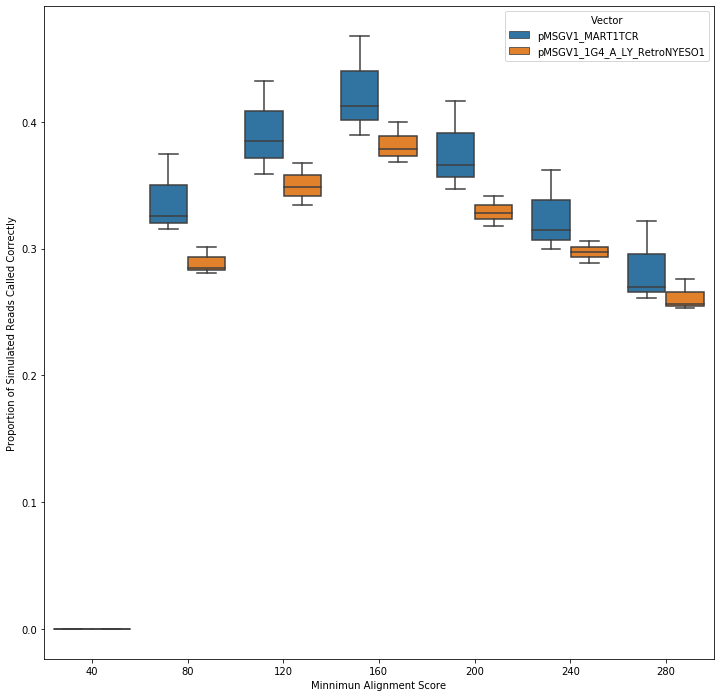

In [204]:
fig, ax = plt.subplots(figsize=(12,12))

sns.boxplot(x='Minnimun Alignment Score', y='On Target Call', data=int_stats_df, ax=ax, hue='Vector')
ax.set_ylabel('Proportion of Simulated Reads Called Correctly')
plt.show()

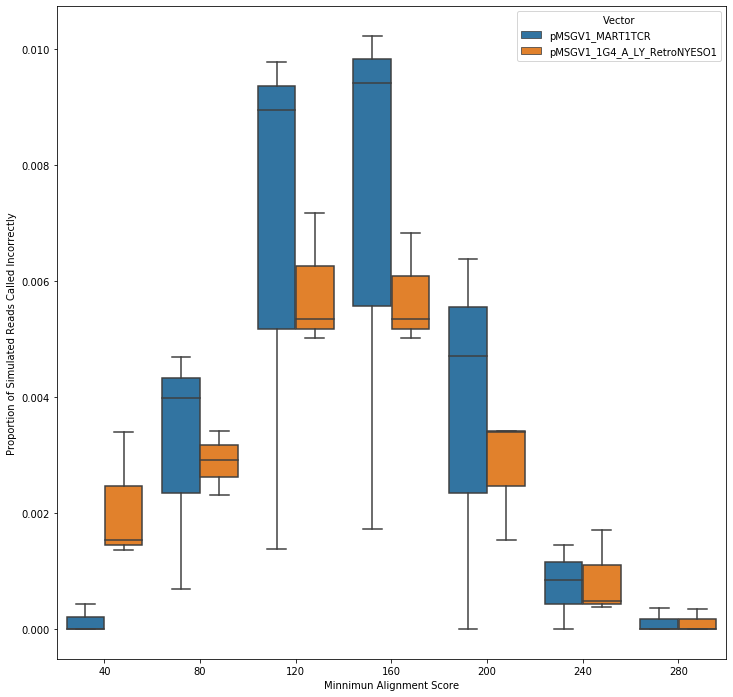

In [205]:
fig, ax = plt.subplots(figsize=(12,12))

sns.boxplot(x='Minnimun Alignment Score', y='Off Target Call', data=int_stats_df, ax=ax, hue='Vector')
ax.set_ylabel('Proportion of Simulated Reads Called Incorrectly')

plt.show()

In [50]:
sum([len(x) for x in integration_reads.values()])

15563

In [51]:
bad_call

0

In [52]:
good_call

854

In [61]:
3145958 - 3145791

167